In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [24]:
import tensorflow as tf

In [25]:
#Specify the path where dataset is stored
df = pd.read_csv('BTC.csv')

In [26]:
df

,timestamp,low,high,open,close,volume
0,1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1,1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
2,1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
3,1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
4,1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000
...,...,...,...,...,...,...
97719,1535214960,6712.990234,6713.140137,6713.000000,6713.140137,0.769891
97720,1535215020,6713.339844,6715.000000,6715.000000,6714.520020,1.002652
97721,1535215080,6714.509766,6714.520020,6714.520020,6714.520020,1.021925
97722,1535215140,6714.520020,6715.000000,6714.520020,6715.000000,3.645508


In [27]:
main_df = df['close'].values

In [66]:
main_df.shape

(97724, 1)

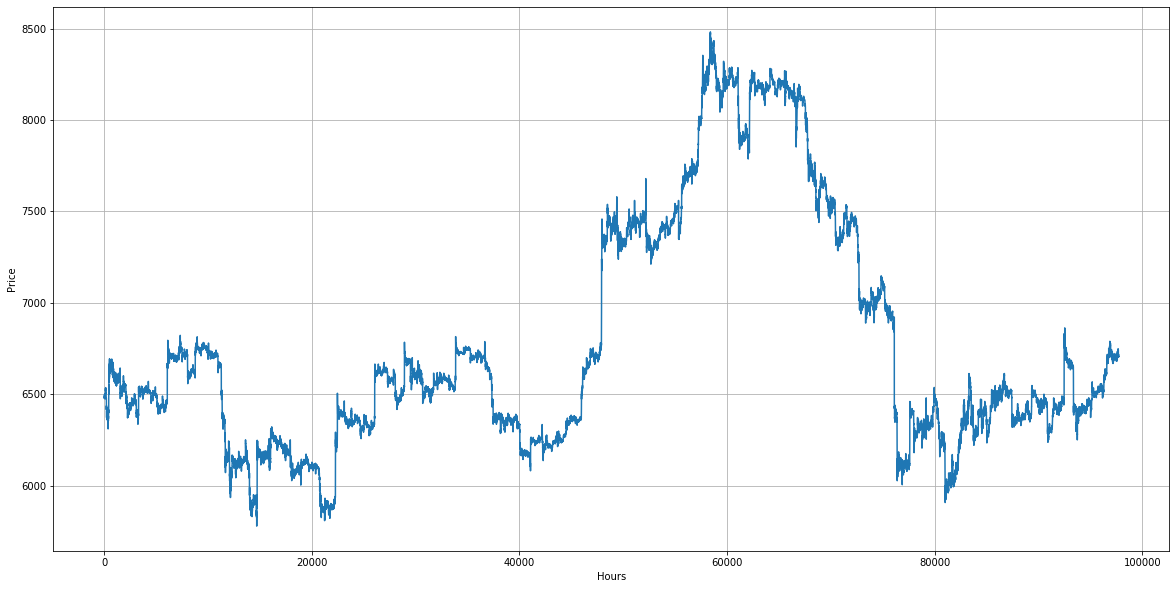

In [28]:
main_df.shape
plt.figure(figsize = (20,10))
plt.plot(main_df)
plt.xlabel('Hours')
plt.ylabel('Price')
plt.grid()

In [29]:
scaler = StandardScaler()
main_df = scaler.fit_transform(main_df.reshape(-1, 1))

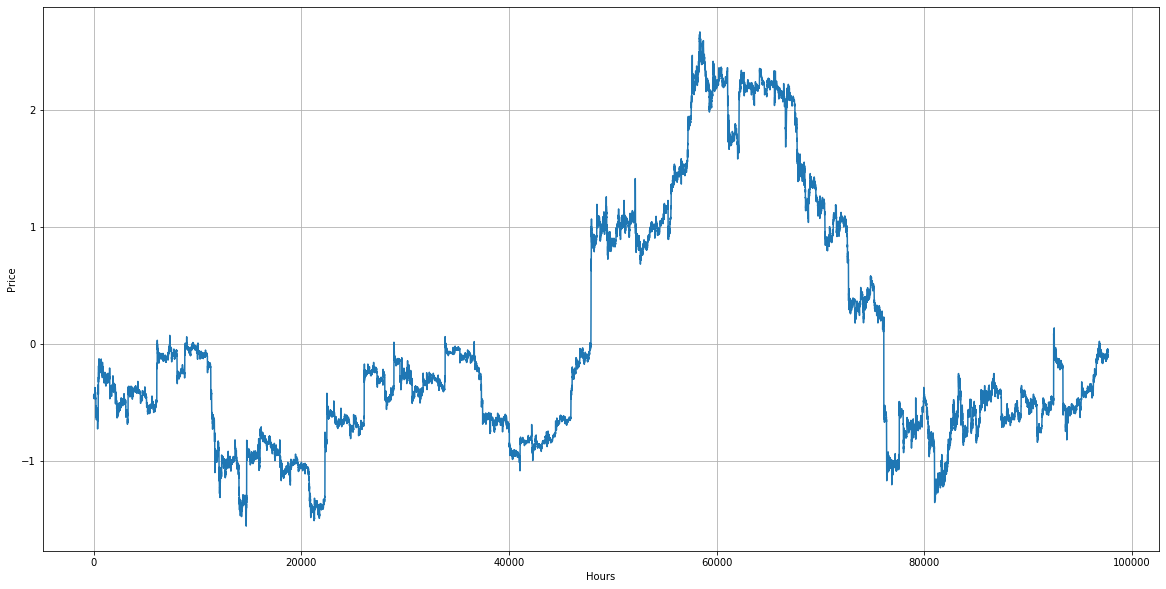

In [30]:
plt.figure(figsize = (20,10))
plt.plot(main_df)
plt.xlabel('Hours')
plt.ylabel('Price')
plt.grid()

In [31]:
def get_data(main_df, window_size):
    X = []
    y = []
    
    i = 0
    
    while (i + window_size) <= len(main_df) - 1:
        X.append(main_df[i:i+window_size])
        y.append(main_df[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [32]:
X, y = get_data(main_df, window_size = 7)

In [72]:
np.array(y).shape

(97717, 1)

In [81]:
dataf = main_df[75000:]

In [33]:
#train set
X_train  = np.array(X[:75000])
y_train = np.array(y[:75000])

#test set
X_test = np.array(X[75000:])
y_test = np.array(y[75000:])

In [73]:
X_test.shape

(22717, 7, 1)

In [82]:
np.array(dataf).shape

(22724, 1)

In [38]:
X_train.shape

(75000, 7, 1)

In [39]:
batch_size = 7
window_size = 7 
hidden_layer = 256 
learning_rate = 0.001

In [40]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
input = tf.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.placeholder(tf.float32, [batch_size, 1])

Instructions for updating:
non-resource variables are not supported in the long term


In [41]:
#Input gate of LSTM
U_input = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_input = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_input = tf.Variable(tf.zeros([hidden_layer]))

In [42]:
#Forget gate of LSTM
U_forget = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_forget = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_forget = tf.Variable(tf.zeros([hidden_layer]))

In [43]:
#Output gate of LSTM
U_output = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_output = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_output = tf.Variable(tf.zeros([hidden_layer]))

In [44]:
#Candidate state for cell state of of each LSTM cell
U_candidate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
W_candidate = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_candidate = tf.Variable(tf.zeros([hidden_layer]))

In [45]:
#Output layere weight and bias of LSTM
V = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

In [46]:
#This function creates a LSTM cell for each data point in dataset
def LSTM_cell(input, prev_hidden_state, prev_cell_state):


    it = tf.sigmoid(tf.matmul(input, U_input) + tf.matmul(prev_hidden_state, W_input) + b_input)

    ft = tf.sigmoid(tf.matmul(input, U_forget) + tf.matmul(prev_hidden_state, W_forget) + b_forget)

    ot = tf.sigmoid(tf.matmul(input, U_output) + tf.matmul(prev_hidden_state, W_output) + b_output)

    gt = tf.tanh(tf.matmul(input, U_candidate) + tf.matmul(prev_hidden_state, W_candidate) + b_candidate)

    ct = (prev_cell_state * ft) + (it * gt)

    ht = ot * tf.tanh(ct)

    return ct, ht

In [47]:
y_hat = []

#compute the output for each batch and store it in the y_hat list
for i in range(batch_size): 
  
    #initialize hidden state and cell state for each batch
    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)
    
    
    #compute the hidden state and cell state of the LSTM cell for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state)
        
    #compute y_hat and append it to y_hat list
    y_hat.append(tf.matmul(hidden_state, V) + b_v)

In [48]:
#Loss calculation for each predicted value.
losses = []

for i in range(len(y_hat)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(target[i], (-1, 1)), y_hat[i]))
    
loss = tf.reduce_mean(losses)

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [49]:
#Gradients clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

In [50]:
#Optimize loss
optimizer = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(gradients, tf.trainable_variables()))

In [51]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [52]:
epochs = 100

In [53]:
#Training model
for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []
    
    #Sample some batche of data and train the network
    while(index + batch_size) <= len(X_train):
        
        #sample batch of data
        X_batch = X_train[index:index+batch_size]
        y_batch = y_train[index:index+batch_size]
        
        #predict the prices and compute loss
        predicted, loss_val, _ = session.run([y_hat, loss, optimizer], feed_dict={input:X_batch, target:y_batch})
        
        #store the loss
        epoch_loss.append(loss_val)
        
        #store the predictions
        train_predictions.append(predicted)
        index += batch_size
        
        
    #print the loss on every iterations
        print('Epoch {}, Loss: {}'.format(i,np.mean(epoch_loss)))

Epoch 0, Loss: 0.002050745068117976
Epoch 10, Loss: 0.00037480596802197397
Epoch 20, Loss: 0.0002376002521486953
Epoch 30, Loss: 0.0001706877665128559
Epoch 40, Loss: 0.00014544755686074495
Epoch 50, Loss: 0.00012648786650970578
Epoch 60, Loss: 0.00011110497143818066
Epoch 70, Loss: 0.00010822855983860791
Epoch 80, Loss: 0.00010354062396800146
Epoch 90, Loss: 0.00010200293763773516


In [54]:
predicted_output = []
i = 0
while i+batch_size <= len(X_test): 
  
    output = session.run([y_hat],feed_dict={input:X_test[i:i+batch_size]})
    i += batch_size
    predicted_output.append(output)

In [116]:
np.array(predicted_output).shape

(3245, 1, 7, 1, 1)

In [58]:
predicted_values_test = []
for i in range(len(predicted_output)):
  for j in range(len(predicted_output[i][0])):
    predicted_values_test.append(predicted_output[i][0][j])

In [147]:
predictions = []
for i in range(97725):
      if i >= 75000:
        predictions.append(predicted_values_test[i-75019])
      else:
        predictions.append(None)

In [191]:
not_none_predictions = filter(None.__ne__,predictions)

In [192]:
list_p = list(not_none_predictions)

In [194]:
np.array(list_p).shape

(22725, 1, 1)

In [196]:
x = np.reshape(list_p,(22725, 1))

In [197]:
np.array(x).shape

(22725, 1)

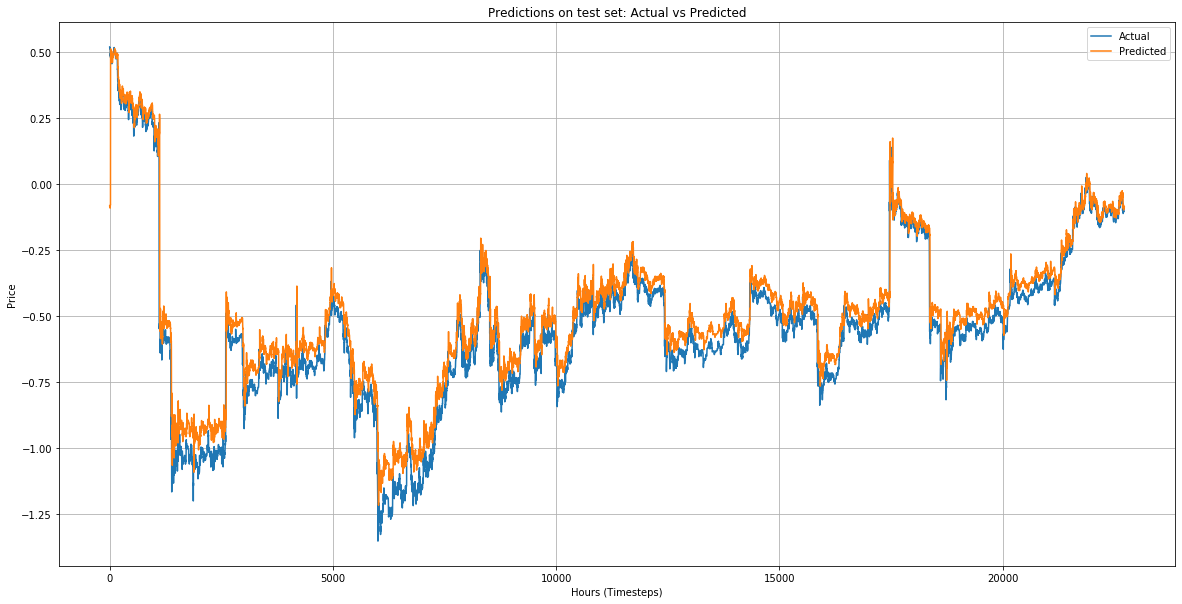

In [224]:
#Plot predicted vs actual values graph
plt.figure(figsize=(20,10))
plt.title('Predictions on test set: Actual vs Predicted')
plt.plot(dataf, label='Actual')
plt.plot(x, label='Predicted')
plt.legend()
plt.xlabel('Hours (Timesteps)')
plt.ylabel('Price')
plt.grid()
plt.show()

In [208]:
saver = tf.train.Saver()

In [209]:
sess = tf.Session()

In [210]:
sess.run(tf.global_variables_initializer())

In [211]:
saver.save(sess, '/home/yaduveer/thesisfinal/Bitcoin_lstm/my_test_model')

'/home/yaduveer/thesisfinal/Bitcoin_lstm/my_test_model'

In [212]:
X_train.shape

(75000, 7, 1)

In [213]:
X_test.shape

(22717, 7, 1)

No handles with labels found to put in legend.


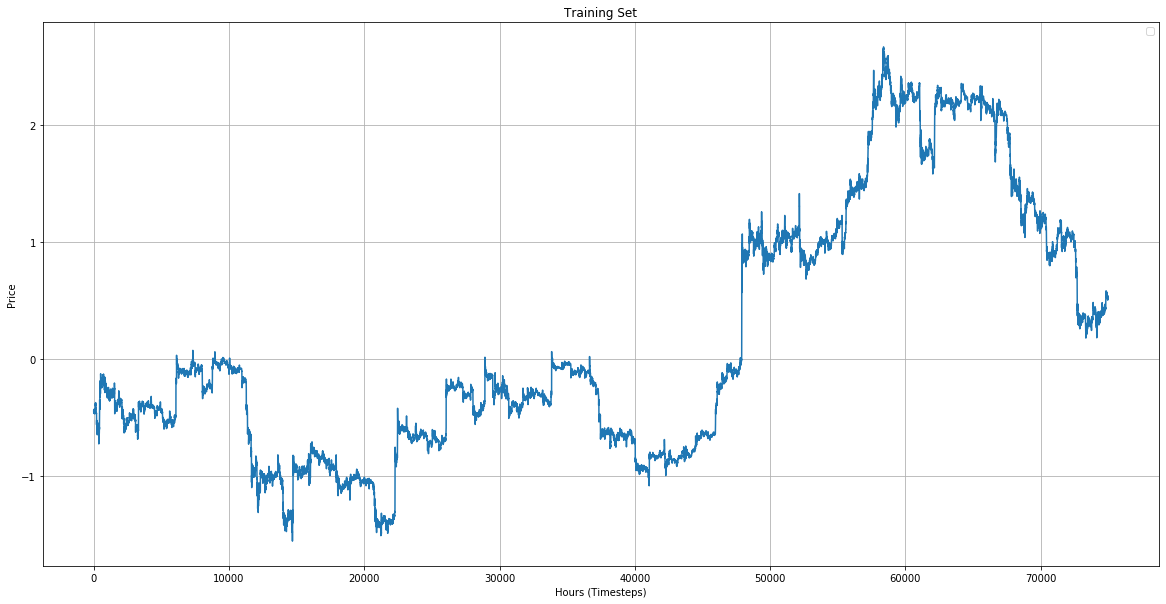

In [232]:
plt.figure(figsize=(20,10))
plt.title('Training Set')
plt.plot(main_df[:75000])
plt.legend()
plt.xlabel('Hours (Timesteps)')
plt.ylabel('Price')
plt.grid()
plt.show()

No handles with labels found to put in legend.


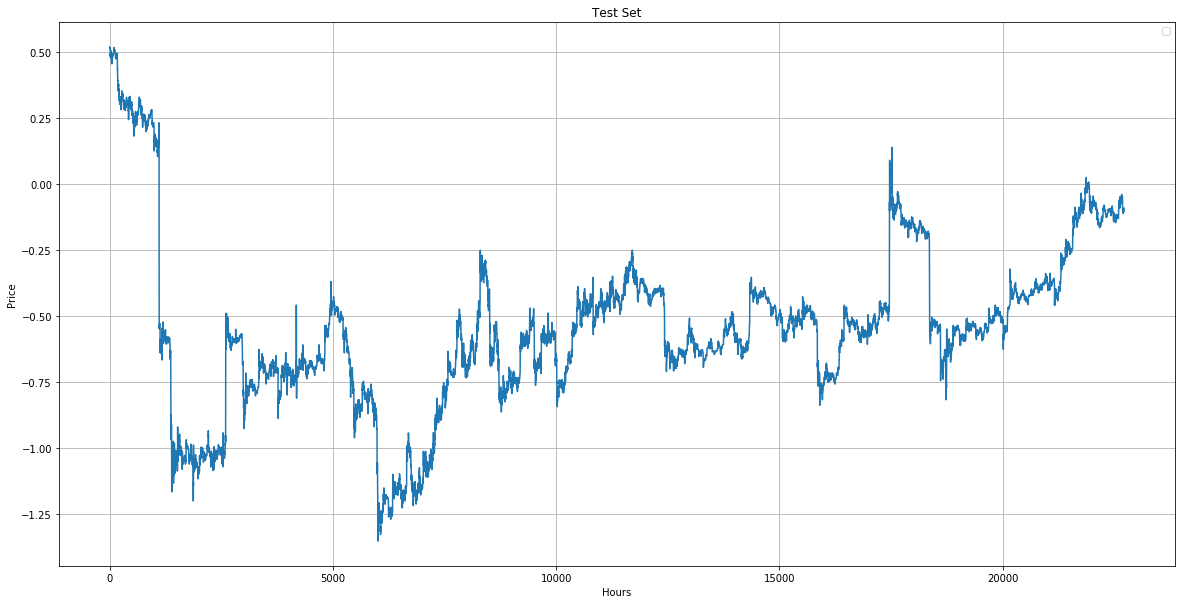

In [222]:
plt.figure(figsize=(20,10))
plt.title('Test Set')
plt.plot(main_df[75000:])
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Price')
plt.grid()
plt.show()


In [230]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [234]:

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, '/home/yaduveer/thesisfinal/Test model 2/my_test_model')

'/home/yaduveer/thesisfinal/Test model 2/my_test_model'